In [1]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO
import os, time
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/nir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Arguments to use throught script

class Arguments:
    def __init__(self):
        
        # Logging and checkpoint
        self.model_path = "./models"
        self.vocab_path = "./data/vocab.pkl"
        self.image_dir = "./data/train2014"
        self.captions_path = "./data/annotations/captions_train2014.json"
        self.log_step = 10
        self.save_step = 1000
        
        # Pretrained model
        self.encoder_path = "./models/encoder-5-3000.ckpt"
        self.decoder_path = "./models/decoder-5-3000.ckpt"
        
        # Network Parameters
        self.embed_size = 256
        self.hidden_size = 512
        self.num_layers = 1
        
        # Training Parameters
        self.num_epochs = 5
        self.batch_size = 2
        self.learning_rate = 0.001

args = Arguments()

### Building Vocabulary

1. All the captions are tokenized and words appearing more than 4 times are considered.
2. Start, End, and Pad tokens are added to help with training and inference.
3. Embeddings are of 256 dimension.
3. If checkpoint file is present, it will read vocabulary from that.

In [3]:
# Vocabulary wrapper class
class Vocabulary():
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.cur = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.cur
            self.idx2word[self.cur] = word
            self.cur += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [4]:
# Build and Save vocabulary.
def build_vocab(annotations_path, threshold):
    coco = COCO(annotations_path)
    counter = Counter()
    # Tokenize all captions
    for i, (idx,info) in enumerate(coco.anns.items()):
        caption = info['caption'].lower().strip()
        tokens = nltk.tokenize.word_tokenize(caption)
        counter.update(tokens)
        
        if (i+1) % 20000 == 0:
            print("{}/{} captions done.".format(i+1, len(coco.anns)))
    
    print("Adding words to vocabulary")
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)
    return vocab

def get_vocab(vocab_path):
    vocab = None
    if os.path.exists(vocab_path):
        print("Reading vocabulary from checkpoint file.")
        with open(vocab_path, "rb") as fh:
            vocab = pickle.load(fh)
    else:
        vocab = build_vocab(args.captions_path, 4)
        print("Saving vocabulary in {}".format(vocab_path))
        with open(vocab_path, "wb") as fh:
            pickle.dump(vocab, fh)
    print("Number of words in Vocabulary: {}".format(len(vocab)))
    return vocab
vocab = get_vocab(args.vocab_path)
print("Vocabulary ready.")

Reading vocabulary from checkpoint file.
Number of words in Vocabulary: 9956
Vocabulary ready.


## Data Loader

### __init__ function:
1. Initializes path
2. Initializes vocabulary
3. Initializes and transformations

### __get_item__:
1. Reads a particular image and its caption.
2. Applies transformation (if present) to the image and resizes it to 224 x 224
3. Appends start and end tokens to the captions.
4. Returns both of them

### collate_fn:
To create minibatches, we need to combine images and their captions into matrices.
1. The images can be combined without any modification.
2. We will need to pad the shorter captions such that all captions in the mini-batch have equal lengths.

In [13]:
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Params:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        image = image.resize([224,224], Image.ANTIALIAS)
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)

def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    Params:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (None)

    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [21]:
# InitializeDataloader

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])
# Build data loader
data_loader = get_loader(args.image_dir, args.captions_path, vocab, 
                         transform, args.batch_size,
                         shuffle=True, num_workers=4) 

loading annotations into memory...
Done (t=5.26s)
creating index...
index created!


In [22]:
for i, (images, captions, lengths) in enumerate(data_loader):
    print(captions.shape)
    break

torch.Size([2, 13])


## Encoder Decoder Model.

> Guide: https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e

### Encoder
1. Pretrained ResNet-152
2. Output: 256 dimension embedding.

### Decoder
1. LSTM RNN
2. Hidder size of 512
2. Word Embeddings of size 256



In [7]:
class EncoderCNN(nn.Module):
    """Resnet-152 with last layer removed. Outputs 256 dimension embedding"""
    
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    """LSTM RNN which inputs whole minibatch at once using packed padded sequences"""
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        print(hiddens[0].size())
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image one word at a time
            Stop when end token is produces or at max length"""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          
            outputs = self.linear(hiddens.squeeze(1))            
            _, predicted = outputs.max(1)                       
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       
            inputs = inputs.unsqueeze(1)                         
        sampled_ids = torch.stack(sampled_ids, 1)                
        return sampled_ids

## Training



In [33]:
# Choose CUDA or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: {}".format(device))

# Build the models
encoder = EncoderCNN(args.embed_size).to(device)
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=args.learning_rate)

# Check if a checkpoint is present
if os.path.exists(args.model_path):
    print("Loading previous checkpoint")
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

# Train the models
total_step = len(data_loader)
for epoch in range(args.num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        #print(lengths, captions.size(), targets.size())
        #print(captions)
        #print(targets)
        #reak

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        #print(outputs)
        #print(outputs.size())
        #print(targets)
        #print(targets.size())
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % args.log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 

        # Save the model checkpoints
        if (i+1) % args.save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                args.model_path, 'decoder.ckpt'))
            torch.save(encoder.state_dict(), os.path.join(
                args.model_path, 'encoder.ckpt'))


Using: cuda
[14, 12] torch.Size([2, 14]) torch.Size([26])
tensor([[   1, 8397,  995, 5411, 4694, 8397,   80, 4694, 3482,  311, 6205, 9667,
         6841,    2],
        [   1, 4525, 8970, 8564, 3858, 2929, 6756, 8397, 8282, 7147,   96,    2,
            0,    0]], device='cuda:0')
tensor([   1,    1, 8397, 4525,  995, 8970, 5411, 8564, 4694, 3858, 8397, 2929,
          80, 6756, 4694, 8397, 3482, 8282,  311, 7147, 6205,   96, 9667,    2,
        6841,    2], device='cuda:0')


## Testing

In [33]:
# Transform for test input does not include Horizontal Flip
test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

def get_caption(encoder, decoder, image_tensor, vocab):
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()  
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption[1:-1])
    return sentence

def cam(encoder, decoder, vocab, idx=0):
    """Continuously captures images from the webcam and classifies them."""

    cap = cv2.VideoCapture(idx)
    
    #Saving output
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter("output.mp4", fourcc, 20.0, (int(cap.get(3)),int(cap.get(4))), 1)
    
    print("Started Capture")
    print("Press q to quit")
    last = time.time()
    prediction = ""
    while(True):
        # Capture frame-by-frame
        try:
            ret, original = cap.read()
            
            if time.time() - last >= 0.5:
                # Resize to 224 x 224 x 3 (H x W x C)
                frame = cv2.resize(original, (224, 224), interpolation = cv2.INTER_AREA)
                image = Image.fromarray(frame)
                # Convert numpy array to torch tensor for forward function
                # Forward function needs shape: (1 x C x H x W)
                image = test_transform(image)
                image = image.unsqueeze(0)
                image = image.to(device)

                prediction = get_caption(encoder, decoder, image, vocab)
                last = time.time()

            # Writing label onto the window
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = (10,650)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2

            cv2.putText(original,prediction, 
                bottomLeftCornerOfText, 
                font, 
                fontScale,
                fontColor,
                lineType)

            # Display captured image
            cv2.imshow("Video", original)
            # Save frame as video
            out.write(original)
            
            if cv2.waitKey(70) & 0xFF == ord('q'):
                break

        except Exception as e:
            print("Exception: {}".format(e))
            break
    # When everything done, release the capture
    print("Ending Capture")
    cap.release()
    cv2.destroyAllWindows()

In [8]:
# Build models for testing from checkpoints.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = EncoderCNN(args.embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(args.encoder_path))
decoder.load_state_dict(torch.load(args.decoder_path))

In [34]:
cam(encoder, decoder, vocab, "./data/testtime/test.mp4")

Started Capture
Press q to quit
Exception: OpenCV(3.4.3) /io/opencv/modules/highgui/src/window.cpp:356: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'

Ending Capture


a man holding a cell phone in his hand .


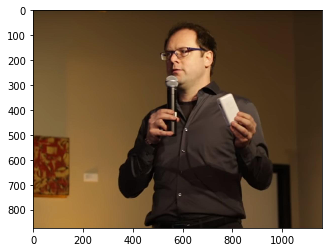

In [64]:
# Caption single images.
def example(encoder, decoder, image_path, vocab):
    
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.ANTIALIAS)
    image = test_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    caption = get_caption(encoder, decoder, image, vocab)
    
    print(caption)
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))
    
example(encoder, decoder, "./data/present.jpeg", vocab)